## Final Project Submission

Please fill out:
* Student name: Collin Loo
* Student pace: part time
* Scheduled project review date/time: 
* Instructor name: James M Irving, Ph.D.
* Blog post URL: 

## Project Roadmap

#### Objectives:
The purpose of this project is to develop a time series model to evaluate if a selected property meet the investment strategy criteria of a real estate investment company.

#### Business Case:
Using historical data, we select five zip codes based on the following requirements.
1. Property must have a price to rent ratio between 12-20 because this is a good indicator for people to decide whether to rent or own a home.  
Calculation:  *median home price / median annual rental*   
where Median Annual Rental = Zillow Rental Index * 12  
    
2. ROI on the sale of the property should be greater than 10%.   
Calculation: (*Sale price after 5 years - (sale price - .25(purchase price)) / 1.25(purchase price)*   
where 0.25 represents the cost of maintaining and the sale of the property.   
    
3. Cash on Cash ratio should be greater than 8%.  
Calculation: *((Rental * 12) - (Mort. Payment + Insurance + Vacancy Allowance)) / (Down Payment + Closing Cost)*  
where Rental = Zillow Rental Index  
Mort. payment = Loan x ((Interest rate/12) x (1+Interest rate/12))sq(Mort. Term) / (1+Interest rate/12))sq(Mort.Term)-1)  
Loan = Property purchase price * 0.80   
Interest rate = 2.5%  
Mort.Term = 360 (30yrs mortgage)  
Insurance = (Property purchase price / 100,000) * 40  
Vacancy Allowance = Rental Index * 0.10  
Down Payment = Property purchase price * 0.20  
Closing Cost = Property purchase price * 0.035  
    
5. Standard deviation of Rental Index should be in the range of 35% to 65 % quantile.  This is to reduce rental market volatility.  
    
6. We will develop the model based on the filtered data set.

#### Project Approach
We will follows the OSEMN framework during the project execution.  Firstly, we will create a base model, using the EDA process to derive the order parameter for the ARIMA model.  Secondly, utilize the grid search process to find the optimum order parameter for the ARIMA model.  Lastly, We will choose the best model based on the lowest Root Mean Square Error that the model produces.

***
## Obtain Data

#### Import Main Dataset

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import itertools
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from my_func import *

%matplotlib inline

In [2]:
df = pd.read_csv('data\zillow_data.csv')
df.head()

RegionID  RegionName      City State              Metro CountyName  \
0     84654       60657   Chicago    IL            Chicago       Cook   
1     90668       75070  McKinney    TX  Dallas-Fort Worth     Collin   
2     91982       77494      Katy    TX            Houston     Harris   
3     84616       60614   Chicago    IL            Chicago       Cook   
4     93144       79936   El Paso    TX            El Paso    El Paso   

   SizeRank   1996-04   1996-05   1996-06  ...  2017-07  2017-08  2017-09  \
0         1  334200.0  335400.0  336500.0  ...  1005500  1007500  1007800   
1         2  235700.0  236900.0  236700.0  ...   308000   310000   312500   
2         3  210400.0  212200.0  212200.0  ...   321000   320600   320200   
3         4  498100.0  500900.0  503100.0  ...  1289800  1287700  1287400   
4         5   77300.0   77300.0   77300.0  ...   119100   119400   120000   

   2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
0  1009600  1013300  1018700  1024400  1030700  1033800  1030600  
1   314100   315000   316600   318100   319600   321100   321800  
2   320400   320800   321200   321200   323000   326900   329900  
3  1291500  1296600  1299000  1302700  1306400  1308500  1307000  
4   120300   120300   120300   120300   120500   121000   121500  

[5 rows x 272 columns]

#### Import Zillow Observed Rent Index (ZORI)

- The Zillow Observed Rent Index can be downloaded from https://www.zillow.com/research/data/
- ROI, price to rent ratio, cash on cash and rental standard deviation are calculated using the rental index and the median home value from the main dataset.  Detail calculation can be found in the Excel spreadsheet in the data directory.  (Metro_ZORI_AllHomesPlusMultifamily_ROI_COC.xlsx)

In [3]:
# import Zillow Observed Rent Index (ZORI)
df_zori = pd.read_csv('data/zori.csv')

# preview data
df_zori.head()

RegionName    ROI  price_to_rent   COC  RentalSTD
0       60657  0.206             50 -0.11      56.00
1       75070  0.449             18  0.03      78.09
2       77494  0.223             19  0.02      42.19
3       60614  0.205             64 -0.12      56.00
4       79936  0.023              9  0.22       6.96

In [4]:
df_zori.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8625 entries, 0 to 8624
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   RegionName     8625 non-null   int64  
 1   ROI            8625 non-null   float64
 2   price_to_rent  8625 non-null   int64  
 3   COC            8625 non-null   float64
 4   RentalSTD      8625 non-null   float64
dtypes: float64(3), int64(2)
memory usage: 337.0 KB


In [5]:
# combine the two dataframes
df_comb = pd.merge(df, df_zori, on='RegionName')

# preview data
df_comb.head()

RegionID  RegionName      City State              Metro CountyName  \
0     84654       60657   Chicago    IL            Chicago       Cook   
1     90668       75070  McKinney    TX  Dallas-Fort Worth     Collin   
2     91982       77494      Katy    TX            Houston     Harris   
3     84616       60614   Chicago    IL            Chicago       Cook   
4     93144       79936   El Paso    TX            El Paso    El Paso   

   SizeRank   1996-04   1996-05   1996-06  ...  2017-11  2017-12  2018-01  \
0         1  334200.0  335400.0  336500.0  ...  1013300  1018700  1024400   
1         2  235700.0  236900.0  236700.0  ...   315000   316600   318100   
2         3  210400.0  212200.0  212200.0  ...   320800   321200   321200   
3         4  498100.0  500900.0  503100.0  ...  1296600  1299000  1302700   
4         5   77300.0   77300.0   77300.0  ...   120300   120300   120300   

   2018-02  2018-03  2018-04    ROI  price_to_rent   COC  RentalSTD  
0  1030700  1033800  1030600  0.206             50 -0.11      56.00  
1   319600   321100   321800  0.449             18  0.03      78.09  
2   323000   326900   329900  0.223             19  0.02      42.19  
3  1306400  1308500  1307000  0.205             64 -0.12      56.00  
4   120500   121000   121500  0.023              9  0.22       6.96  

[5 rows x 276 columns]

***
## Preprocess Data

In [6]:
# examine columns 
df_comb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8625 entries, 0 to 8624
Columns: 276 entries, RegionID to RentalSTD
dtypes: float64(222), int64(50), object(4)
memory usage: 18.2+ MB


### Subset Data Based on Investment Strategies

**Subset the data based on the following assumptions:**
1. Properties must have a price to rent ration between 12 - 20 as this is a good indicator
   for people to choose renting over owning.
2. Return on investment should be greater than 10%.
3. Cash on cash return rate should be greater than 8%.
4. Rental index standard deviation should be within the 30% to 60% quantile to minimize
   risk and volatility.

In [8]:
# filter data
p_to_r = df_comb[(df_comb['price_to_rent'] > 11) & (df_comb['price_to_rent'] < 20)]
roi = p_to_r[p_to_r['ROI'] > 0.10]
c_on_c = roi[roi['COC'] > 0.08]
q_low, q_high = c_on_c['RentalSTD'].quantile([.3, .6])
df_filtered = c_on_c[(c_on_c['RentalSTD'] >= q_low) & (c_on_c['RentalSTD'] <= q_high)]

# preview filtered data
df_filtered.head()

RegionID  RegionName          City State        Metro   CountyName  \
17      92593       78660  Pflugerville    TX       Austin       Travis   
23      69816       28269     Charlotte    NC    Charlotte  Mecklenburg   
72      92598       78666    San Marcos    TX       Austin         Hays   
103     69672       28027       Concord    NC    Charlotte     Cabarrus   
105     92336       78240   San Antonio    TX  San Antonio        Bexar   

     SizeRank   1996-04   1996-05   1996-06  ...  2017-11  2017-12  2018-01  \
17         19  138900.0  138600.0  138400.0  ...   238500   239400   240000   
23         25  126100.0  126600.0  127100.0  ...   191700   193500   195100   
72         78  103100.0  103000.0  103000.0  ...   196900   197500   197900   
103       112  126600.0  127300.0  127700.0  ...   210400   212000   213700   
105       114  100900.0  100800.0  100700.0  ...   179400   180300   181600   

     2018-02  2018-03  2018-04    ROI  price_to_rent   COC  RentalSTD  
17    241000   242200   242800  0.350             14  0.10      59.30  
23    196600   198500   199700  0.364             12  0.13      73.69  
72    200100   203800   206500  0.360             12  0.15      59.30  
103   215200   216700   218000  0.282             13  0.11      73.69  
105   182800   183900   184800  0.288             12  0.13      51.40  

[5 rows x 276 columns]

**To diversify our investment profile, we will pick the top 5 zip codes based on:**
1. Property showing highest ROI.
2. One zip code per State.

In [12]:
# get list of States
states = list(set(df_filtered.State))
df_top_states = pd.DataFrame()

# select top zip code from each state
for state in states:
    tmp = df_filtered[(df_filtered['State'] == state)]
    df_top_states = df_top_states.append(tmp[tmp['ROI'] == tmp['ROI'].max()])
    
# select the top 5 zip codes
df_top_zc = df_top_states.sort_values(by=['ROI'], ascending=False)

# preview dataframe
df_top_zc.head(15)

RegionID  RegionName            City State                Metro  \
1618     95800       89104       Las Vegas    NV            Las Vegas   
5882     71858       32204    Jacksonville    FL         Jacksonville   
2890     79075       48220        Ferndale    MI              Detroit   
3257     69485       27701          Durham    NC               Durham   
7328     66581       20722       Brentwood    MD           Washington   
225      66142       20019      Washington    DC           Washington   
387      92651       78741          Austin    TX               Austin   
461      65815       19148    Philadelphia    PA         Philadelphia   
4652     94464       84104  Salt Lake City    UT       Salt Lake City   
3320     82103       55102      Saint Paul    MN  Minneapolis-St Paul   
7060     74365       37403     Chattanooga    TN          Chattanooga   
3513     97397       93654         Reedley    CA               Fresno   
298      84641       60641         Chicago    IL              Chicago   
8561     63356       14008         Newfane    NY              Buffalo   
8499    100088       99110         Clayton    WA              Spokane   

                CountyName  SizeRank   1996-04   1996-05   1996-06  ...  \
1618                 Clark      1961   94800.0   94700.0   94700.0  ...   
5882                 Duval      8260   41400.0   41400.0   41500.0  ...   
2890               Oakland      3703   61000.0   61600.0   62300.0  ...   
3257                Durham      4196   79900.0   80300.0   80800.0  ...   
7328        Prince Georges     11135   99300.0   98800.0   98300.0  ...   
225   District of Columbia       247   91300.0   91000.0   90600.0  ...   
387                 Travis       433   93800.0   93600.0   93500.0  ...   
461           Philadelphia       519   41100.0   41100.0   41000.0  ...   
4652             Salt Lake      6212   93600.0   93700.0   93800.0  ...   
3320                Ramsey      4279   68100.0   68000.0   67900.0  ...   
7060              Hamilton     10535   55200.0   55300.0   55500.0  ...   
3513                Fresno      4562   98400.0   98300.0   98200.0  ...   
298                   Cook       333  135700.0  136200.0  136400.0  ...   
8561               Niagara     14533   66700.0   66700.0   66600.0  ...   
8499               Stevens     14304       NaN       NaN       NaN  ...   

      2017-11  2017-12  2018-01  2018-02  2018-03  2018-04    ROI  \
1618   192500   196300   199500   202500   206000   208500  1.119   
5882   169000   170400   174000   178700   181200   180900  1.086   
2890   155600   156800   158600   160700   162500   163500  1.001   
3257   210900   214200   215800   220000   226400   229900  0.879   
7328   274700   276100   277300   278900   281700   284100  0.809   
225    308800   310800   313400   314100   311800   308600  0.678   
387    234100   238300   241000   243600   247400   250400  0.648   
461    199700   201000   202000   203800   207400   210100  0.601   
4652   202800   205600   207800   211000   215500   218500  0.589   
3320   218500   220600   223500   225900   227800   229100  0.584   
7060   179800   180200   180600   180700   180800   181700  0.520   
3513   213700   216200   219000   221600   223900   225900  0.493   
298    286100   286900   288300   289800   291000   291500  0.489   
8561   138300   139300   140000   141400   141700   140700  0.462   
8499   190100   189900   186300   182700   181000   178800  0.438   

      price_to_rent   COC  RentalSTD  
1618             13  0.10      67.54  
5882             12  0.14      51.18  
2890             12  0.15      44.05  
3257             14  0.09      55.31  
7328             12  0.15      43.29  
225              13  0.12      43.29  
387              14  0.09      59.30  
461              12  0.15      46.07  
4652             14  0.09      70.87  
3320             13  0.12      68.87  
7060             13  0.10      51.71  
3513             14  0.09      63.98  
298              14  0.0

### Format Data for Time Series

In [13]:
# define non-date columns
id_vars = ['RegionID', 'RegionName', 'City','State', 'Metro', 'CountyName',
            'SizeRank', 'ROI', 'price_to_rent', 'COC', 'RentalSTD']

df_ts = pd.melt(df_top_zc, id_vars=id_vars, var_name='time')
df_ts['time'] = pd.to_datetime(df_ts['time'], infer_datetime_format=True)
# preview dataframe
df_ts.head(10)

RegionID  RegionName            City State                Metro  \
0     95800       89104       Las Vegas    NV            Las Vegas   
1     71858       32204    Jacksonville    FL         Jacksonville   
2     79075       48220        Ferndale    MI              Detroit   
3     69485       27701          Durham    NC               Durham   
4     66581       20722       Brentwood    MD           Washington   
5     66142       20019      Washington    DC           Washington   
6     92651       78741          Austin    TX               Austin   
7     65815       19148    Philadelphia    PA         Philadelphia   
8     94464       84104  Salt Lake City    UT       Salt Lake City   
9     82103       55102      Saint Paul    MN  Minneapolis-St Paul   

             CountyName  SizeRank    ROI  price_to_rent   COC  RentalSTD  \
0                 Clark      1961  1.119             13  0.10      67.54   
1                 Duval      8260  1.086             12  0.14      51.18   
2               Oakland      3703  1.001             12  0.15      44.05   
3                Durham      4196  0.879             14  0.09      55.31   
4        Prince Georges     11135  0.809             12  0.15      43.29   
5  District of Columbia       247  0.678             13  0.12      43.29   
6                Travis       433  0.648             14  0.09      59.30   
7          Philadelphia       519  0.601             12  0.15      46.07   
8             Salt Lake      6212  0.589             14  0.09      70.87   
9                Ramsey      4279  0.584             13  0.12      68.87   

        time    value  
0 1996-04-01  94800.0  
1 1996-04-01  41400.0  
2 1996-04-01  61000.0  
3 1996-04-01  79900.0  
4 1996-04-01  99300.0  
5 1996-04-01  91300.0  
6 1996-04-01  93800.0  
7 1996-04-01  41100.0  
8 1996-04-01  93600.0  
9 1996-04-01  68100.0

In [14]:
zip_codes = [37403, 93654, 60641, 14008, 99110] #df_ts['RegionName'].unique()
zip_codes

[37403, 93654, 60641, 14008, 99110]

***
## Explore Data

### General Plot of Home Values

In [15]:
plot_ts(df_ts)

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>The declining trend started around the beginning of 2007 can be attributed to the 2008 real estate bubble burst.
        <li>Miami home values dropped the most during the crisis.  One of the reason, , according to the inflation-adjusted home-price appreciation from 1998-2006, is that Miami home-price appreciation exceeded 80% for that time period.  However, it also showed the strongest recovery in home value years later after the crisis.</li>
        <li>Farmers Branch, TX was least affected by the crisis.  This can also be explain by the inflation-adjusted home-price appreciation from 1998-2006 data.  Texas and other few states had less than 20% Home-Price Appreciation from 1998 to 2006.</li>
        <li>We will exclude data prior to 2009 for our analysis because of this structural break in the time series.</li>
    </ul>
</div>

In [11]:
# subset data after the 2008 crisis
df_ts_af_crisis = df_ts[df_ts.time > '2008-12-01']
plot_ts(df_ts_af_crisis)

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>It appears there is a recovery period of about two to three years before we see an upward trend in home values.</li>
        <li>Zip code 33125 out paced the rest of the cities in term of home values appreciation.</li>
        <li>Data exhibits a linear upward trend, thus detrending will be required prior to modeling.</li>
        <li>No obvious seasonality detected.  We will decompose the time series and investigate further.</li>
    </ul>
</div>

### Home Values Data Distribution

In [ ]:
px_displot(df_ts_af_crisis)

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>Data seem to resemble a normal distribution.</li>
        <li>Data also seem right skewed.</li>
    </ul>
</div>

### Box and Whisker plot

In [ ]:
# plot the boxplot for the five cities
for zc in zip_codes:
    tmp = get_data_by_zc(df_ts_af_crisis, zc)
    
    # Use pandas grouper to group values using annual frequency
    tmp_yr = tmp['2009':'2017'].groupby(pd.Grouper(freq ='A'))
    tmp_annual = pd.DataFrame()
    
    for yr, group in tmp_yr:
        tmp_annual[yr.year] = group.values.ravel()

    fig = go.Figure()
    for year in tmp_annual.columns:
        fig.add_trace(go.Box(y=tmp_annual[year], name=year))
        fig.update_layout(title=f'Annual Home Values -{zc}',
                          xaxis_title="Year",
                          yaxis_title="Value"
                         )
        fig.update_xaxes(showline=True, linewidth=1, linecolor='gray', mirror=True)
        fig.update_yaxes(showline=True, linewidth=1, linecolor='gray', mirror=True)
    fig.show()

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>No major outliers detected in the five cities.</li>
        <li>The average home values in the subsequent years after 2012, jump up significantly.</li>
        <li>The mean of home values dependents on time.</li>
    </ul>
</div>

### Stationarity Check

ARMA model requires time series to be stationary.  Since our time series exhibit a linear upward trend, we will need to remove such trend using one of the detrending methods, differencing, and deploy Augmented Dickey=Fuller (ADF) test to validate our results.  In addition, we will subset the top 5 zip codes data set using cutoff date of 2011-12-01.

In [16]:
 df_ts_af_crisis = df_ts[df_ts.time > '2011-12-01']
stationarity_diff_chk(df_ts_af_crisis, zip_codes, periods=1, plot=True, diff_n=1)

Test Statistic   p-value  #Lags Used  \
37403, Differencing       -2.990652  0.035777           2   
93654, Differencing       -2.602413  0.092500           3   
60641, Differencing       -4.016393  0.001327           3   
14008, Differencing       -4.184422  0.000700          11   
99110, Differencing       -1.898708  0.332669           8   

                     # of Observations Used  p<.05  Stationary?  
37403, Differencing                      72   True         True  
93654, Differencing                      71  False        False  
60641, Differencing                      71   True         True  
14008, Differencing                      63   True         True  
99110, Differencing                      66  False        False

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>Performing differencing on the top 5 cities only resulted in 2 of them meeting the stationary assumption.</li>
        <li>We will use d=1 for the 33125 and 55102.
    </ul>
</div>

In [17]:
# perform 2nd order differencing
stationarity_diff_chk(df_ts_af_crisis, zipcode=[93654, 99110],
                      periods=1, plot=True, diff_n=2)

Test Statistic       p-value  #Lags Used  \
93654, Differencing      -10.343389  2.649185e-18           1   
99110, Differencing       -5.019448  2.030805e-05           6   

                     # of Observations Used  p<.05  Stationary?  
93654, Differencing                      72   True         True  
99110, Differencing                      67   True         True

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>The 2nd order differencing seemed to take care of the stationary issues.</li>
        <li>The d parameter of the ARIMA model will be 2 for 85042, 75234 and 84104.</li>
    </ul>
</div>

### Autocorrelation

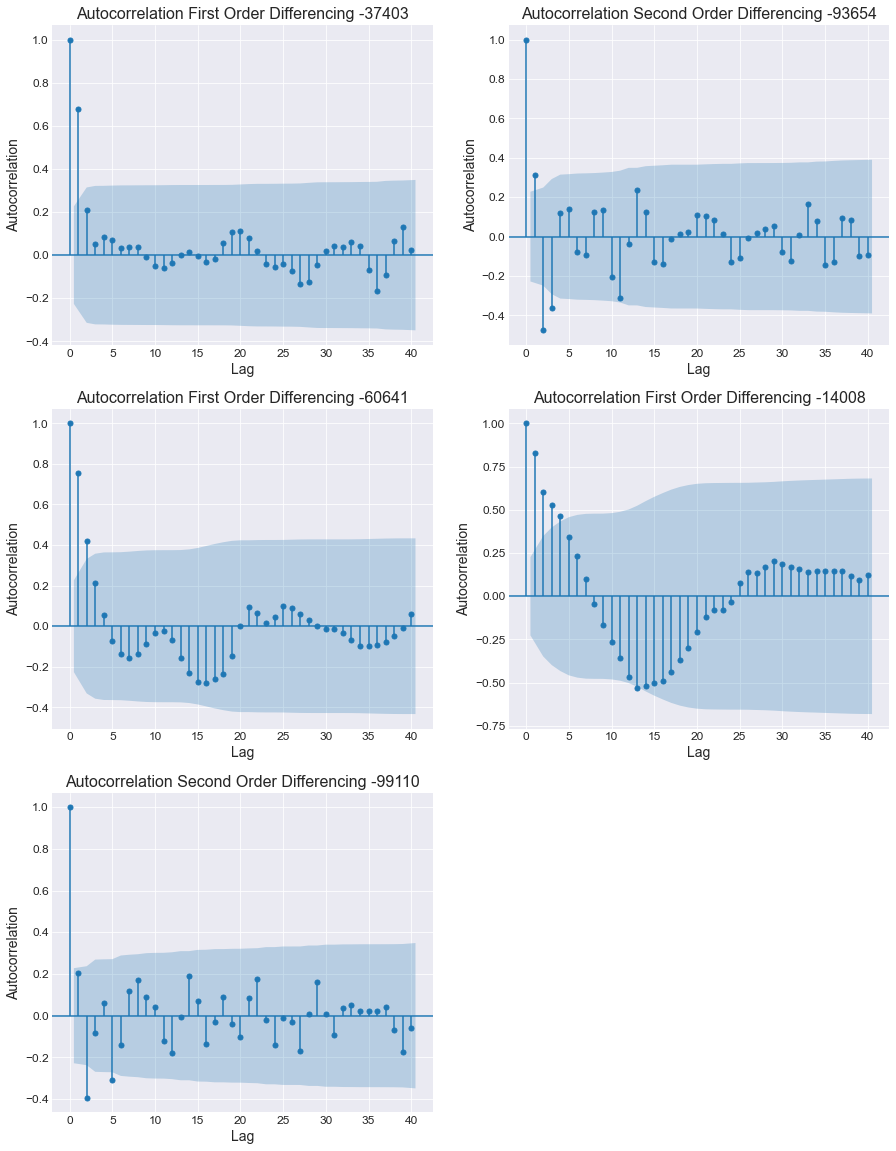

In [19]:
# # plot the autocorrelation by city
plot_acf_pacf(df_ts_af_crisis, [37403, 14008, 60641],
              [93654, 99110], [], zip_codes, p_type='acf')    

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>We can based on the ACF plot to estimate the term for the Moving Average(MA) model.  In this case, we would have:
            <ul>
                <li>q_33125 = 2</li>
                <li>q_85042 = 2</li>
                <li>q_75234 = 3</li>
                <li>q_84104 = 2-3</li>
                <li>q_55102 = 2</li>
           </ul>
        </li>
    </ul>
</div>

### Partial Autocorrelation Plot

D:\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1406: RuntimeWarning:

invalid value encountered in sqrt

D:\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1406: RuntimeWarning:

invalid value encountered in sqrt



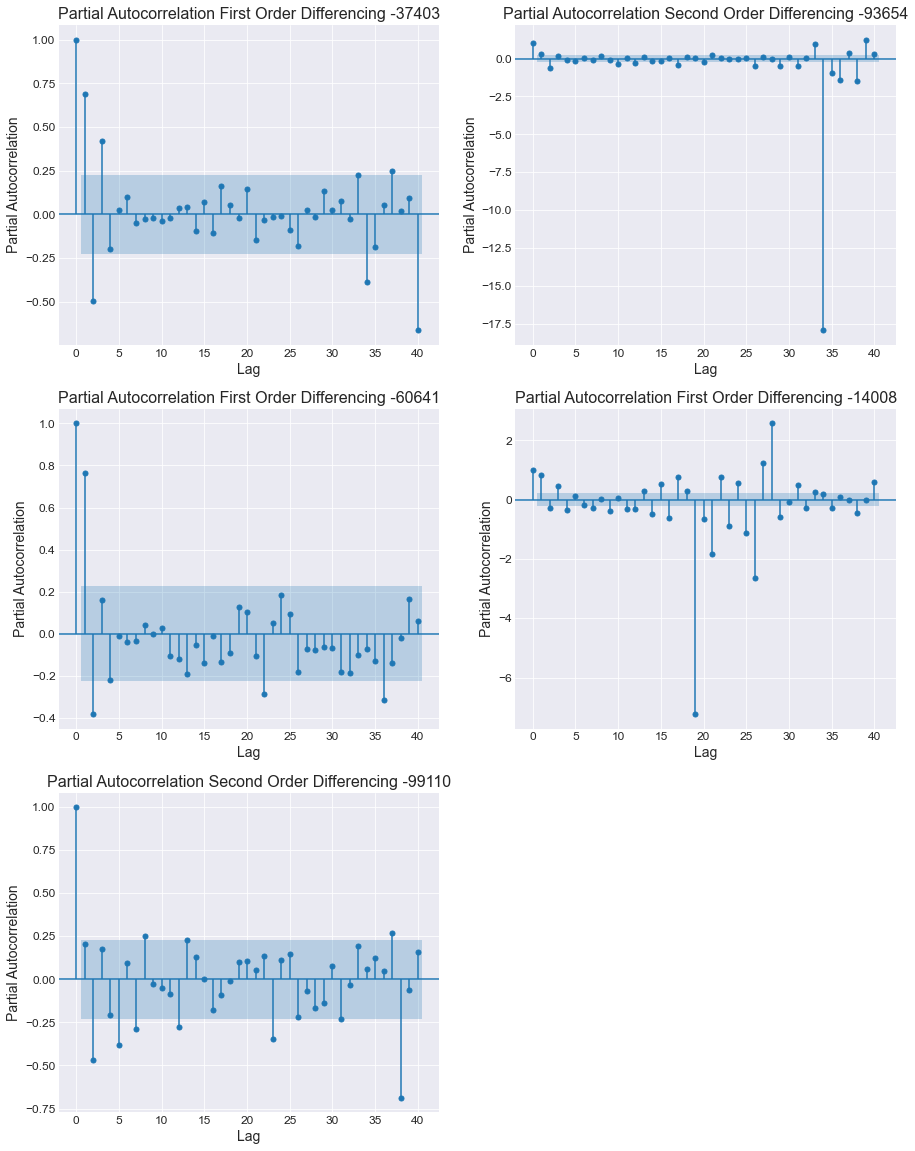

In [20]:
# plot partial autocorrelation by city
plot_acf_pacf(df_ts_af_crisis, [37403, 14008, 60641],
              [93654, 99110], [], zip_codes, p_type='pacf')    

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>We can based on the PACF plot to estimate the term for the AutoRegressive Average(AR) model.  In this case, we would have:
            <ul>
                <li>q_mi = 2</li>
                <li>q_ph = 2</li>
                <li>q_fa = 2</li>
                <li>q_sa = 2</li>
                <li>q_sp = 2-4</li>
           </ul>
        </li>
    </ul>
</div>

### Decompose Trend

In [ ]:
# Plot trend decomposition
for zc in zip_codes:
    # Import and apply seasonal_decompose()
    decomposition = seasonal_decompose(get_data_by_zc(df_ts_af_crisis, zc),\
                                       model='additive')

    # Gather the trend, seasonality, and residuals 
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    # Plot gathered statistics
    with plt.style.context('seaborn-darkgrid'):
        fig, axs = plt.subplots(4, 1,figsize=(9, 9))
        axs[0].plot(get_data_by_zc(df_ts_af_crisis, zc), label='Original')
        axs[0].legend(fancybox=True)
        axs[1].plot(trend, label='Trend')
        axs[1].legend(fancybox=True)
        axs[2].plot(seasonal, label='Seasonal')
        axs[2].legend(fancybox=True)
        axs[3].plot(residual, label='Residuals')
        axs[3].legend(fancybox=True)
        fig.suptitle(f'Time Series Decomposition, Zip Code {zc}', fontsize=14)
        plt.show()

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>Seasonality plots show very little seasonal trend.
    </ul>
</div>

***
## Base Model (Model A) Using Manual PDQ

### Define Train and Test Data Set Cutoff

In [21]:
# separate data into train and validation set
df_train = df_ts_af_crisis[(df_ts_af_crisis.time > '2011-12-01')
                           & (df_ts_af_crisis.time < '2016-06-01')]
df_val = df_ts_af_crisis[(df_ts_af_crisis.time > '2016-05-01')]

# verify no data overlap
display(df_train.tail(3))
display(df_val.head(3))

# check train data set percent allocated
print(f'\n*** Percent allocated to train set:\
      {round(len(df_train)/len(df_ts_af_crisis), 2)} ***')

RegionID  RegionName         City State         Metro  CountyName  \
7015     66028       19702       Newark    DE  Philadelphia  New Castle   
7016     71298       30736     Ringgold    GA   Chattanooga     Catoosa   
7017     60899        8002  Cherry Hill    NJ  Philadelphia      Camden   

      SizeRank    ROI  price_to_rent   COC  RentalSTD       time     value  
7015       590  0.197             12  0.15      46.07 2016-05-01  195200.0  
7016      1406  0.195             12  0.14      51.71 2016-05-01  140800.0  
7017      4509  0.168             13  0.11      46.07 2016-05-01  206900.0

RegionID  RegionName          City State         Metro CountyName  \
7018     95800       89104     Las Vegas    NV     Las Vegas      Clark   
7019     71858       32204  Jacksonville    FL  Jacksonville      Duval   
7020     79075       48220      Ferndale    MI       Detroit    Oakland   

      SizeRank    ROI  price_to_rent   COC  RentalSTD       time     value  
7018      1961  1.119             13  0.10      67.54 2016-06-01  154200.0  
7019      8260  1.086             12  0.14      51.18 2016-06-01  149100.0  
7020      3703  1.001             12  0.15      44.05 2016-06-01  130800.0


*** Percent allocated to train set:      0.7 ***


### ARIMA Order Parameters

In [ ]:
# store pdq parameters for each city in a dataframe
arima_param_a = pd.DataFrame({'zc':zip_codes, 'pdq':[(1,1,2), (2,2,0), (1,2,1), (2,2,0), (1,1,1)]},
                            columns = ['zc', 'pdq'])
arima_param_a  

In [ ]:
# define prediction start date
pred_sd_a = '2013-01-01'

### Zip Code 33125 ARIMA Results

#### Coefficient P-Values and Diagnostic Plots

In [ ]:
# define emptly list to store mse and rmse
out_list_a = []

# fit model and plot diagnostic figures
fit_arima_model(df_train, arima_param_a, 33125)

#### One-Step Ahead Forecast (dynamic=False)

In [ ]:
output_a = one_step_fc_arima(df_train, arima_param_a, 33125, pred_start_date=pred_sd_a)
out_list_a.append(output_a)

#### One-Step Ahead Forecast (dynamic=True)

In [ ]:
output_a = one_step_fc_arima(df_train, arima_param_a, 33125, pred_start_date=pred_sd_a, dynamic=True)
out_list_a.append(output_a)

### Zip Code  85042 Results

#### Coefficient P-Values and Diagnostic Plots

In [ ]:
fit_arima_model(df_train, arima_param_a, 85042)

#### One-Step Ahead Forecast (dynamic=False)

In [ ]:
output_a = one_step_fc_arima(df_train, arima_param_a, 85042, pred_start_date=pred_sd_a)
out_list_a.append(output_a)

#### One-Step Ahead Forecast (dynamic-True)

In [ ]:
output_a = one_step_fc_arima(df_train, arima_param_a, 85042, pred_start_date=pred_sd_a, dynamic=True)
out_list_a.append(output_a)

### Zip Code 75234 ARIMA Results

#### Coefficient P-Values and Diagnostic Plots

In [ ]:
fit_arima_model(df_train, arima_param_a, 75234)

#### One-Step Ahead Forecast (dynamic=False)

In [ ]:
output_a = one_step_fc_arima(df_train, arima_param_a, 75234, pred_start_date=pred_sd_a)
out_list_a.append(output_a)

#### One-Step Ahead Forecast (Dynamic=True)

In [ ]:
output_a = one_step_fc_arima(df_train, arima_param_a, 75234,
                             pred_start_date=pred_sd_a, dynamic=True)
out_list_a.append(output_a)

### Zip Code 84104 ARIMA Results

#### Coefficient P-Values and Diagnostic Plots

In [ ]:
fit_arima_model(df_train, arima_param_a, 84104)

#### One-Step Ahead Forecast (dynamic=False)

In [ ]:
output_a = one_step_fc_arima(df_train, arima_param_a, 84104, pred_start_date=pred_sd_a)
out_list_a.append(output_a)

#### One-Step Ahead Forecast (dynamic=True)

In [ ]:
output_a = one_step_fc_arima(df_train, arima_param_a, 84104,
                             pred_start_date=pred_sd_a, dynamic=True)
out_list_a.append(output_a)

### Zip Code 55102 ARIMA Results

#### Coefficient P-Values and Diagnostic Plots

In [ ]:
fit_arima_model(df_train, arima_param_a, 55102)

#### One-Step Ahead Forecast (dynamic=False)

In [ ]:
output_a = one_step_fc_arima(df_train, arima_param_a, 55102, pred_start_date=pred_sd_a)
out_list_a.append(output_a)

#### One-Step Ahead Forecast (dynamic=True)

In [ ]:
output_a = one_step_fc_arima(df_train, arima_param_a, 55102,
                             pred_start_date=pred_sd_a, dynamic=True)
out_list_a.append(output_a)

### RMSE Results

In [ ]:
df_mse_a = pd.DataFrame.from_dict(out_list_a)
df_mse_a.sort_values('dynamic')

In [ ]:
plot_forecast_rmse(df_mse_a)

### Model A Validation

In [ ]:
# defince prediction start date for validation data set
pred_date_a_val = '2017-04-01'

### Zip Code 33125 Validation Results

#### Coefficient P-Values and Diagnostic Plots

In [ ]:
# define empty list to store mse and rmse
out_list_a_val = []

# fit and plot diagnostic figures
fit_arima_model(df_val, arima_param_a, 33125)

#### One-Step Ahead Forecast (dynamic=False)

In [ ]:
output_a_val = one_step_fc_arima(df_val, arima_param_a, 33125, pred_start_date=pred_date_a_val)
out_list_a_val.append(output_a_val)

#### One-Step Ahead Forecast (dynamic=True)

In [ ]:
output_a_val = one_step_fc_arima(df_val, arima_param_a, 33125,
                                 pred_start_date=pred_date_a_val, dynamic=True)
out_list_a_val.append(output_a_val)

### Zip Code 85042 Validation Results

#### Coefficient P-Values and Diagnostic Plots

In [ ]:
fit_arima_model(df_val, arima_param_a, 85042)

#### One-Step Ahead Forecast (dynamic=False)

In [ ]:
output_a_val = one_step_fc_arima(df_val, arima_param_a, 85042, pred_start_date=pred_date_a_val)
out_list_a_val.append(output_a_val)

#### One-Step Ahead Forecast (dynamic-True)

In [ ]:
output_a_val = one_step_fc_arima(df_val, arima_param_a, 85042,
                                 pred_start_date=pred_date_a_val, dynamic=True)
out_list_a_val.append(output_a_val)

### Zip Code 75234 Validation Results

#### Coefficient P-Values and Diagnostic Plots

In [ ]:
fit_arima_model(df_val, arima_param_a, 75234)

#### One-Step Ahead Forecast (dynamic=False)

In [ ]:
output_a_val = one_step_fc_arima(df_val, arima_param_a, 75234,
                                 pred_start_date=pred_date_a_val)
out_list_a_val.append(output_a_val)

#### One-Step Ahead Forecast (Dynamic=True)

In [ ]:
output_a_val = one_step_fc_arima(df_val, arima_param_a, 75234,
                                 pred_start_date=pred_date_a_val, dynamic=True)
out_list_a_val.append(output_a_val)

### Zip Code 84104 Validation Results

#### Coefficient P-Values and Diagnostic Plots

In [ ]:
fit_arima_model(df_val, arima_param_a, 84104)

#### One-Step Ahead Forecast (dynamic=False)

In [ ]:
output_a_val = one_step_fc_arima(df_val, arima_param_a, 84104,
                                 pred_start_date=pred_date_a_val)
out_list_a_val.append(output_a_val)

#### One-Step Ahead Forecast (dynamic=True)

In [ ]:
output_a_val = one_step_fc_arima(df_val, arima_param_a, 84104,
                                 pred_start_date=pred_date_a_val, dynamic=True)
out_list_a_val.append(output_a_val)

### Zip Code 55102 Validation Results

#### Coefficient P-Values and Diagnostic Plots

In [ ]:
fit_arima_model(df_val, arima_param_a, 55102)

#### One-Step Ahead Forecast (dynamic=False)

In [ ]:
output_a_val = one_step_fc_arima(df_val, arima_param_a, 55102,
                                 pred_start_date=pred_date_a_val)
out_list_a_val.append(output_a_val)

#### One-Step Ahead Forecast (dynamic=True)

In [ ]:
output_a_val = one_step_fc_arima(df_val, arima_param_a, 55102,
                                 pred_start_date=pred_date_a_val, dynamic=True)
out_list_a_val.append(output_a_val)

### Validation RMSE Results

In [ ]:
df_mse_a_val = pd.DataFrame.from_dict(out_list_a_val)
df_mse_a_val.sort_values('dynamic')

In [ ]:
plot_forecast_rmse(df_mse_a_val)

***
## Model B

### Generate pdq Combinations

In [24]:
# gen arima model with range = 0,2
# define p,d & q parameters
p = d = q = range(0,3)

# generate different combination of p,d,q
pdq = list(itertools.product(p,d,q))
print(pdq)

[(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 1, 0), (0, 1, 1), (0, 1, 2), (0, 2, 0), (0, 2, 1), (0, 2, 2), (1, 0, 0), (1, 0, 1), (1, 0, 2), (1, 1, 0), (1, 1, 1), (1, 1, 2), (1, 2, 0), (1, 2, 1), (1, 2, 2), (2, 0, 0), (2, 0, 1), (2, 0, 2), (2, 1, 0), (2, 1, 1), (2, 1, 2), (2, 2, 0), (2, 2, 1), (2, 2, 2)]


### Grid Search Optimum pdq

In [25]:
# select ariama model based on lowest AIC scores
arima_param_b = gen_arima_params(df_train, zip_codes, pdq, enf_stationarity=False)

# display optimum pdq from grid search
arima_param_b

zc        pdq         AIC
26   37403  (2, 2, 2)  786.948549
53   93654  (2, 2, 2)  746.291061
80   60641  (2, 2, 2)  767.802409
107  14008  (2, 2, 2)  787.394077
113  99110  (0, 1, 2)  805.850347

In [26]:
# define prediction start date
pred_sd_b = '2013-01-01'

### Zip Code 33125 ARIMA Results

#### Coefficient P-Values and Diagnostic Plots

In [27]:
zc_1 = 37403

*** Coefficients Statistics, 37403 ***


<class 'statsmodels.iolib.table.SimpleTable'>

*** SARIMAX Diagnostics Plot, 37403 ***


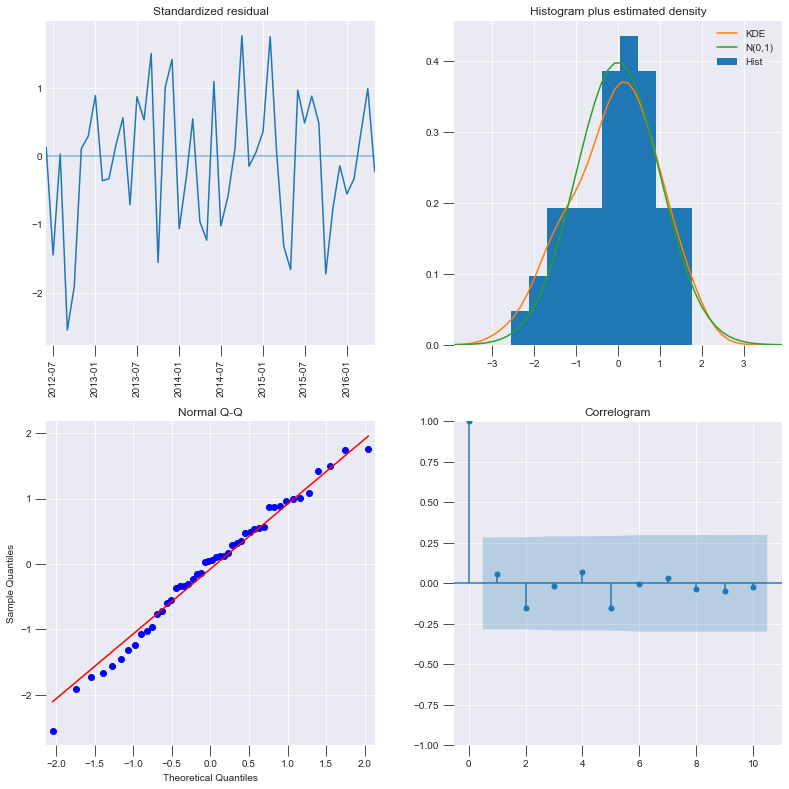

In [28]:
# define empty list to store mse and rmse
out_list_b = []

# fit model and plot diagnostic figures
fit_arima_model(df_train, arima_param_b, zc_1)

#### One-Step Ahead Forecast (dynamic=False)

In [29]:
output_b = one_step_fc_arima(df_train, arima_param_b, zc_1, pred_start_date=pred_sd_b)
out_list_b.append(output_b)

The mean square error of our forcast is : 543469.75.
The root mean square error of our forcast is 737.2.


#### One-Step Ahead Forecast (dynamic=True)

In [30]:
output_b = one_step_fc_arima(df_train, arima_param_b, zc_1,
                             pred_start_date=pred_sd_b, dynamic=True)
out_list_b.append(output_b)

The mean square error of our forcast is : 748922474.19.
The root mean square error of our forcast is 27366.45.


### Zip Code 85042 ARIMA Results

#### Coefficient P-Values and Diagnostic Plots

In [31]:
zc_2 = 93654

*** Coefficients Statistics, 93654 ***


<class 'statsmodels.iolib.table.SimpleTable'>

*** SARIMAX Diagnostics Plot, 93654 ***


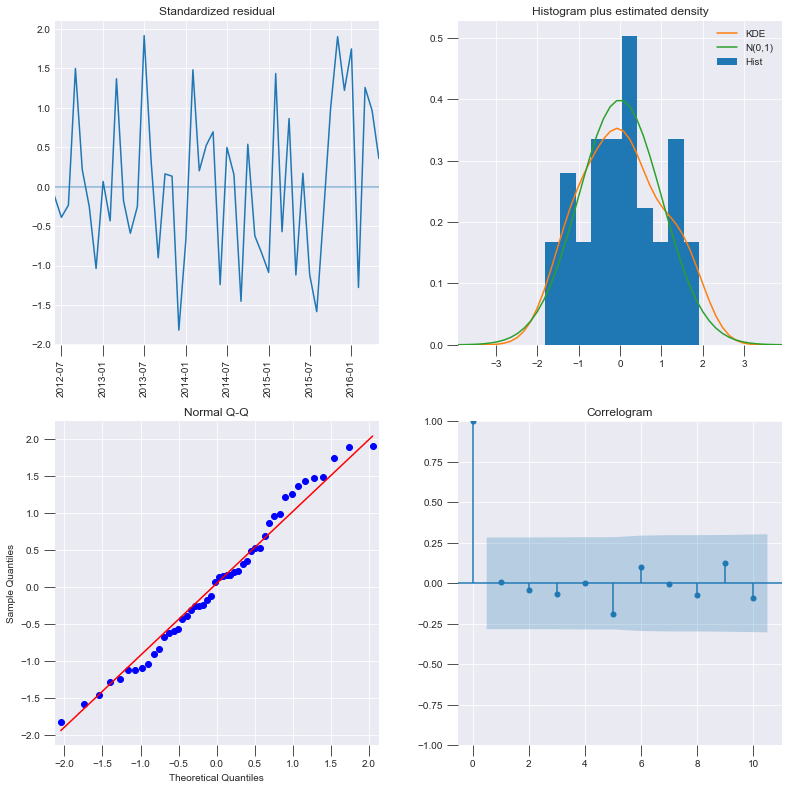

In [32]:
fit_arima_model(df_train, arima_param_b, zc_2)

#### One-Step Ahead Forecast (dynamic=False)

In [33]:
output_b = one_step_fc_arima(df_train, arima_param_b, zc_2, pred_start_date=pred_sd_b)
out_list_b.append(output_b)

The mean square error of our forcast is : 289117.6.
The root mean square error of our forcast is 537.7.


#### One-Step Ahead Forecast (dynamic-True)

In [34]:
output_b = one_step_fc_arima(df_train, arima_param_b, zc_2,
                             pred_start_date=pred_sd_b, dynamic=True)
out_list_b.append(output_b)

The mean square error of our forcast is : 28393888.61.
The root mean square error of our forcast is 5328.59.


### Zip Code 75234 ARIMA Results

#### Coefficient P-Values and Diagnostic Plots

In [36]:
zc_3 = 60641

*** Coefficients Statistics, 60641 ***


<class 'statsmodels.iolib.table.SimpleTable'>

*** SARIMAX Diagnostics Plot, 60641 ***


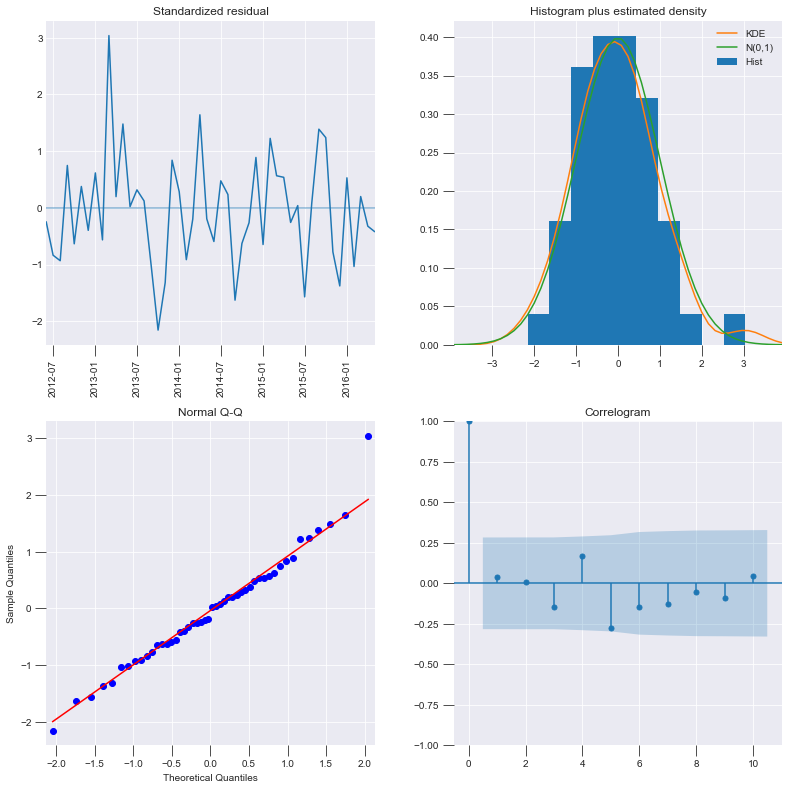

In [37]:
fit_arima_model(df_train, arima_param_b, zc_3)

#### One-Step Ahead Forecast (dynamic=False)

In [38]:
output_b = one_step_fc_arima(df_train, arima_param_b, zc_3, pred_start_date=pred_sd_b)
out_list_b.append(output_b)

The mean square error of our forcast is : 458853.19.
The root mean square error of our forcast is 677.39.


#### One-Step Ahead Forecast (Dynamic=True)

In [39]:
output_b = one_step_fc_arima(df_train, arima_param_b, zc_3,
                             pred_start_date=pred_sd_b, dynamic=True)
out_list_b.append(output_b)

The mean square error of our forcast is : 2812658529.63.
The root mean square error of our forcast is 53034.5.


### Zip Code 84104 ARIMA Results

#### Coefficient P-Values and Diagnostic Plots

In [40]:
zc_4 = 14008

*** Coefficients Statistics, 14008 ***


<class 'statsmodels.iolib.table.SimpleTable'>

*** SARIMAX Diagnostics Plot, 14008 ***


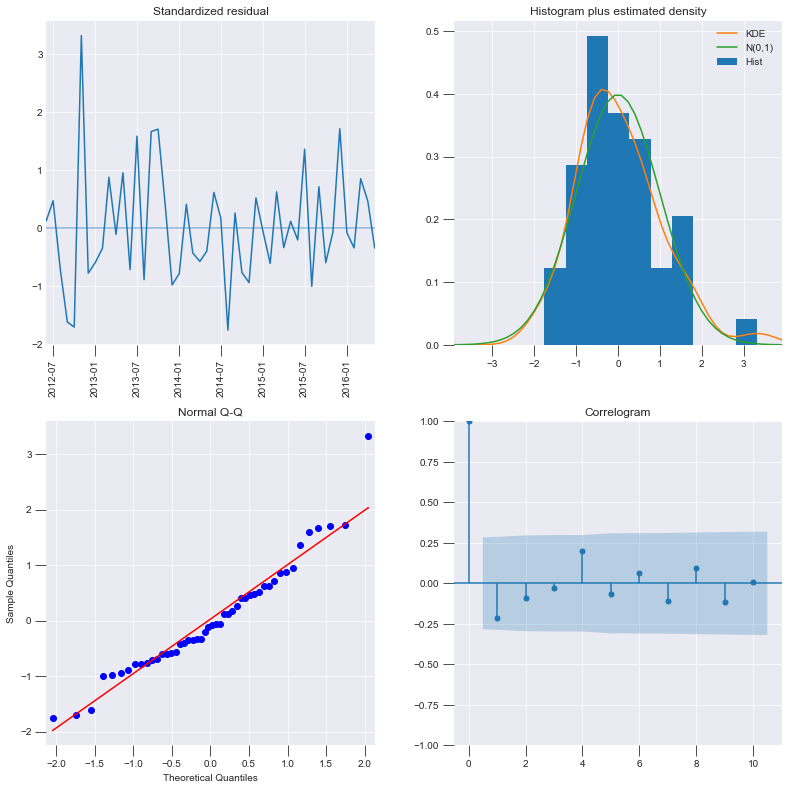

In [41]:
fit_arima_model(df_train, arima_param_b, zc_4)

#### One-Step Ahead Forecast (dynamic=False)

In [42]:
output_b = one_step_fc_arima(df_train, arima_param_b, zc_4, pred_start_date=pred_sd_b)
out_list_b.append(output_b)

The mean square error of our forcast is : 442878.44.
The root mean square error of our forcast is 665.49.


#### One-Step Ahead Forecast (dynamic=True)

In [43]:
output_b = one_step_fc_arima(df_train, arima_param_b, zc_4,
                             pred_start_date=pred_sd_b, dynamic=True)
out_list_b.append(output_b)

The mean square error of our forcast is : 1611217740.38.
The root mean square error of our forcast is 40139.98.


### Zip Code 55102 ARIMA Results

#### Coefficient P-Values and Diagnostic Plots

In [44]:
zc_5 = 99110

*** Coefficients Statistics, 99110 ***


<class 'statsmodels.iolib.table.SimpleTable'>

*** SARIMAX Diagnostics Plot, 99110 ***


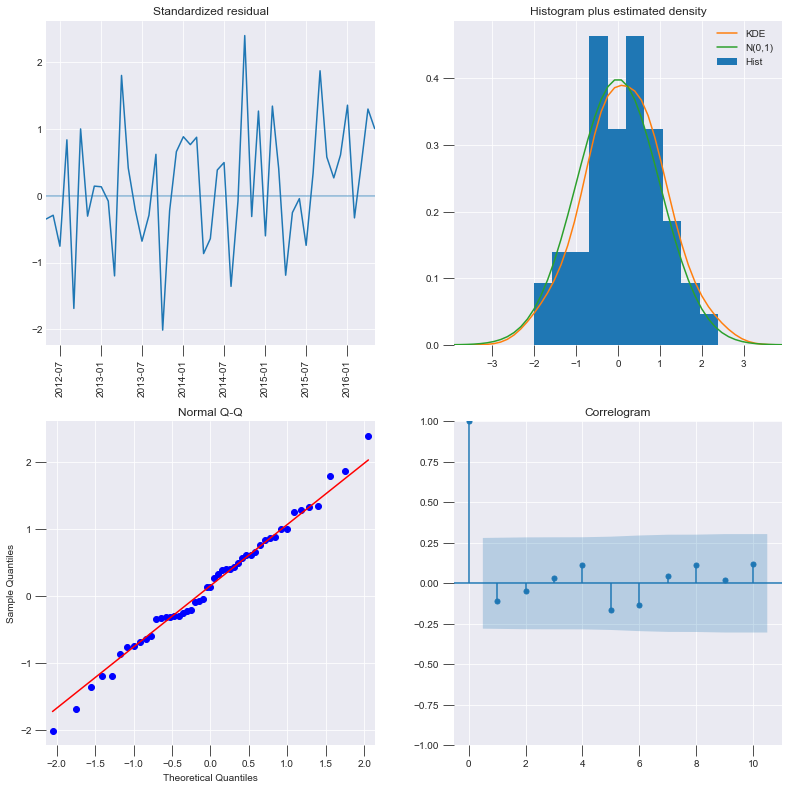

In [45]:
fit_arima_model(df_train, arima_param_b, zc_5)

#### One-Step Ahead Forecast (dynamic=False)

In [46]:
output_b = one_step_fc_arima(df_train, arima_param_b, zc_5, pred_start_date=pred_sd_b)
out_list_b.append(output_b)

The mean square error of our forcast is : 726715.37.
The root mean square error of our forcast is 852.48.


#### One-Step Ahead Forecast (dynamic=True)

In [47]:
output_b = one_step_fc_arima(df_train, arima_param_b, zc_5,
                             pred_start_date=pred_sd_b, dynamic=True)
out_list_b.append(output_b)

The mean square error of our forcast is : 74163731.96.
The root mean square error of our forcast is 8611.84.


### RMSE Results

In [48]:
df_mse_b = pd.DataFrame.from_dict(out_list_b)
df_mse_b.sort_values('dynamic')

zc  dynamic                                             output  \
0  37403    False  <statsmodels.tsa.statespace.sarimax.SARIMAXRes...   
2  93654    False  <statsmodels.tsa.statespace.sarimax.SARIMAXRes...   
4  60641    False  <statsmodels.tsa.statespace.sarimax.SARIMAXRes...   
6  14008    False  <statsmodels.tsa.statespace.sarimax.SARIMAXRes...   
8  99110    False  <statsmodels.tsa.statespace.sarimax.SARIMAXRes...   
1  37403     True  <statsmodels.tsa.statespace.sarimax.SARIMAXRes...   
3  93654     True  <statsmodels.tsa.statespace.sarimax.SARIMAXRes...   
5  60641     True  <statsmodels.tsa.statespace.sarimax.SARIMAXRes...   
7  14008     True  <statsmodels.tsa.statespace.sarimax.SARIMAXRes...   
9  99110     True  <statsmodels.tsa.statespace.sarimax.SARIMAXRes...   

            mse      rmse  
0  5.434698e+05    737.20  
2  2.891176e+05    537.70  
4  4.588532e+05    677.39  
6  4.428784e+05    665.49  
8  7.267154e+05    852.48  
1  7.489225e+08  27366.45  
3  2.839389e+07   5328.59  
5  2.812659e+09  53034.50  
7  1.611218e+09  40139.98  
9  7.416373e+07   8611.84

In [49]:
plot_forecast_rmse(df_mse_b)

### Model B Validation

In [ ]:
# defince prediction start date for validation data set
pred_date_b_val = '2017-04-01'

### Zip Code 33125 Validation Results

#### Coefficient P-Values and Diagnostic Plots

In [ ]:
# define empty list to store mse and rmse 
out_list_b_val = []

# fit model and plot diagnostic figures
fit_arima_model(df_val, arima_param_b, 33125)

#### One-Step Ahead Forecast (dynamic=False)

In [ ]:
output_b_val = one_step_fc_arima(df_val, arima_param_b, 33125, pred_start_date=pred_date_b_val)
out_list_b_val.append(output_b_val)

#### One-Step Ahead Forecast (dynamic=True)

In [ ]:
output_b_val = one_step_fc_arima(df_val, arima_param_b, 33125,
                                 pred_start_date=pred_date_b_val, dynamic=True)
out_list_b_val.append(output_b_val)

### Zip Code 85042 Validation Results

#### Coefficient P-Values and Diagnostic Plots

In [ ]:
fit_arima_model(df_val, arima_param_b, 85042)

#### One-Step Ahead Forecast (dynamic=False)

In [ ]:
output_b_val = one_step_fc_arima(df_val, arima_param_b, 85042, pred_start_date=pred_date_b_val)
out_list_b_val.append(output_b_val)

#### One-Step Ahead Forecast (dynamic-True)

In [ ]:
output_b_val = one_step_fc_arima(df_val, arima_param_b, 85042,
                                 pred_start_date=pred_date_b_val, dynamic=True)
out_list_b_val.append(output_b_val)

### Zip Code 75234 Validation Results

#### Coefficient P-Values and Diagnostic Plots

In [ ]:
fit_arima_model(df_val, arima_param_b, 75234)

#### One-Step Ahead Forecast (dynamic=False)

In [ ]:
output_b_val = one_step_fc_arima(df_val, arima_param_b, 75234, pred_start_date=pred_date_b_val)
out_list_b_val.append(output_b_val)

#### One-Step Ahead Forecast (Dynamic=True)

In [ ]:
output_b_val = one_step_fc_arima(df_val, arima_param_b, 75234,
                                 pred_start_date=pred_date_b_val, dynamic=True)
out_list_b_val.append(output_b_val)

### Zip Code 84104 Validation Results

#### Coefficient P-Values and Diagnostic Plots

In [ ]:
fit_arima_model(df_val, arima_param_b, 84104)

#### One-Step Ahead Forecast (dynamic=False)

In [ ]:
output_b_val = one_step_fc_arima(df_val, arima_param_b, 84104, pred_start_date=pred_date_b_val)
out_list_b_val.append(output_b_val)

#### One-Step Ahead Forecast (dynamic=True)

In [ ]:
output_b_val = one_step_fc_arima(df_val, arima_param_b, 84104,
                                 pred_start_date=pred_date_b_val, dynamic=True)
out_list_b_val.append(output_b_val)

### Zip Code 55102 Validation Results

#### Coefficient P-Values and Diagnostic Plots

In [ ]:
fit_arima_model(df_val, arima_param_b, 55102)

#### One-Step Ahead Forecast (dynamic=False)

In [ ]:
output_b_val = one_step_fc_arima(df_val, arima_param_b, 55102, pred_start_date=pred_date_b_val)
out_list_b_val.append(output_b_val)

#### One-Step Ahead Forecast (dynamic=True)

In [ ]:
output_b_val = one_step_fc_arima(df_val, arima_param_b, 55102,
                                 pred_start_date=pred_date_b_val, dynamic=True)
out_list_b_val.append(output_b_val)

### Validation RMSE Results

In [ ]:
df_mse_b_val = pd.DataFrame.from_dict(out_list_b_val)
df_mse_b_val.sort_values('dynamic')

In [ ]:
plot_forecast_rmse(df_mse_b_val)

## Model C - SARIMA

### Generate pdq and PDQ Parameters

In [ ]:
# gen arima model with range = 0,2
# define p,d & q parameters
p = d = q = range(0,3)

# generate different combination of p,d,q
pdq = list(itertools.product(p,d,q))
print(pdq)

# generate different combination of P,D,Q
PDQ = [(x[0], x[1], x[2], 2) for x in pdq]
print(PDQ)

# filter out d > 1
PDQ_rev = []
for x in PDQ:
    if x[1] < 2:
        PDQ_rev.append(x)

### Grid Search Optimum pdq And PDQ

In [ ]:
# select ariama model based on lowest AIC scores

sarima_param_c = gen_sarima_params(df_train, zip_codes, pdq[:-3], PDQ_rev,enf_stationarity=False)

# display optimum pdq from grid search
sarima_param_c

In [ ]:
# define prediction start date
pred_sd_c = '2013-01-01'

### Zip Code 33125 SARIMA Resutls

#### Coefficient P-Values and Diagnostic Plots

In [ ]:
# define emptly list to store mse and rmse
out_list_c = []

# fit model and plot diagnostic figures
fit_sarima_model(df_train, sarima_param_c, 33125)

#### One-Step Ahead Forecast (dynamic=False)

In [ ]:
output_c = one_step_fc_sarima(df_train, sarima_param_c, 33125, pred_start_date=pred_sd_c)
out_list_c.append(output_c)

#### One-Step Ahead Forecast (dynamic=True)

In [ ]:
output_c = one_step_fc_sarima(df_train, sarima_param_c, 33125,
                             pred_start_date=pred_sd_c, dynamic=True)
out_list_c.append(output_c)

### Zip Code 85042 SARIMA Resutls

#### Coefficient P-Values and Diagnostic Plots

In [ ]:
fit_sarima_model(df_train, sarima_param_c, 85042)

#### One-Step Ahead Forecast (dynamic=False)

In [ ]:
output_c = one_step_fc_sarima(df_train, sarima_param_c, 85042, pred_start_date=pred_sd_c)
out_list_c.append(output_c)

#### One-Step Ahead Forecast (dynamic=True)

In [ ]:
output_c = one_step_fc_sarima(df_train, sarima_param_c, 85042,
                             pred_start_date=pred_sd_c, dynamic=True)
out_list_c.append(output_c)

### Zip Code 75234 SARIMA Resutls

#### Coefficient P-Values and Diagnostic Plots

In [ ]:
fit_sarima_model(df_train, sarima_param_c, 75234)

#### One-Step Ahead Forecast (dynamic=False)

In [ ]:
output_c = one_step_fc_sarima(df_train, sarima_param_c, 75234, pred_start_date=pred_sd_c)
out_list_c.append(output_c)

#### One-Step Ahead Forecast (dynamic=True)

In [ ]:
output_c = one_step_fc_sarima(df_train, sarima_param_c, 75234,
                             pred_start_date=pred_sd_c, dynamic=True)
out_list_c.append(output_c)

### Zip Code 84104 SARIMA Resutls

#### Coefficient P-Values and Diagnostic Plots

In [ ]:
fit_sarima_model(df_train, sarima_param_c, 84104)

#### One-Step Ahead Forecast (dynamic=False)

In [ ]:
output_c = one_step_fc_sarima(df_train, sarima_param_c, 84104, pred_start_date=pred_sd_c)
out_list_c.append(output_c)

In [ ]:
output_c = one_step_fc_sarima(df_train, sarima_param_c, 84104,
                             pred_start_date=pred_sd_c, dynamic=True)
out_list_c.append(output_c)

#### One-Step Ahead Forecast (dynamic=True)

### Zip Code 55102 SARIMA Resutls

#### Coefficient P-Values and Diagnostic Plots

In [ ]:
fit_sarima_model(df_train, sarima_param_c, 55102)

#### One-Step Ahead Forecast (dynamic=False)

In [ ]:
output_c = one_step_fc_sarima(df_train, sarima_param_c, 55102, pred_start_date=pred_sd_c)
out_list_c.append(output_c)

#### One-Step Ahead Forecast (dynamic=True)

In [ ]:
output_c = one_step_fc_sarima(df_train, sarima_param_c, 55102,
                             pred_start_date=pred_sd_c, dynamic=True)
out_list_c.append(output_c)

### RSME Results

In [ ]:
df_mse_c = pd.DataFrame.from_dict(out_list_c)
df_mse_c.sort_values('dynamic')

In [ ]:
plot_forecast_rmse(df_mse_c)

## Model Interpretatioin

### Compare Models' RMSEs

In [58]:
# comparing Model RMSE
filter_rmse = pd.DataFrame()
for df , model in list(zip([df_mse_b], ['B''C'])):
    tmp = df[df['dynamic'] == True][['zc','rmse']]
    tmp['model'] = model
    filter_rmse = pd.concat([filter_rmse, tmp])
    
plot_forecast_rmse(filter_rmse, x='zc', color='model')

#### Define Forecast Model Parameters

In [50]:
# define final parameters for arima and sarima
df_fc = df_ts[df_ts.time > '2011-12-01']
arima_fc_param = arima_param_b
# arima_fc_param = pd.concat([arima_param_a.iloc[1:2, :], arima_param_b.iloc[2:4, 0:2],
#                              arima_param_a.iloc[4:, :]], axis=0)
# sarima_fc_param = sarima_param_c.iloc[0:1, :]

# preview data
display(df_fc.head())
print('***  ARIMA Parameters ***')
display(arima_fc_param)
# print('***  SARIMA Parameters ***')
# display(sarima_fc_param)


RegionID  RegionName          City State         Metro      CountyName  \
5481     95800       89104     Las Vegas    NV     Las Vegas           Clark   
5482     71858       32204  Jacksonville    FL  Jacksonville           Duval   
5483     79075       48220      Ferndale    MI       Detroit         Oakland   
5484     69485       27701        Durham    NC        Durham          Durham   
5485     66581       20722     Brentwood    MD    Washington  Prince Georges   

      SizeRank    ROI  price_to_rent   COC  RentalSTD       time     value  
5481      1961  1.119             13  0.10      67.54 2012-01-01   68800.0  
5482      8260  1.086             12  0.14      51.18 2012-01-01   77000.0  
5483      3703  1.001             12  0.15      44.05 2012-01-01   62300.0  
5484      4196  0.879             14  0.09      55.31 2012-01-01  116300.0  
5485     11135  0.809             12  0.15      43.29 2012-01-01  128700.0

***  ARIMA Parameters ***


zc        pdq         AIC
26   37403  (2, 2, 2)  786.948549
53   93654  (2, 2, 2)  746.291061
80   60641  (2, 2, 2)  767.802409
107  14008  (2, 2, 2)  787.394077
113  99110  (0, 1, 2)  805.850347

In [54]:
def get_arima_fc(df, zc, a_fc_param, s_fc_param=None, steps=60, sarima=False):
    '''
    Docstring:    Get and plot model forecast results.
    Signature:    get_arima_fc(
                  df=none,
                  zc=none,
                  step=60,
                  fc_param=arima_fc_param
    Parameters:   df: Pandas dataframe
                  zc: int, zip code
                  fc_param: Pandas dataframe
                  step: int
                  )
    Return:       Forecast values, confident interval values and plotly figure                      
    '''
    import warnings
    warnings.filterwarnings("ignore")
    tmp = get_data_by_zc(df, zc)
    
    # fit model
    if sarima:
        pdq = s_fc_param[s_fc_param['zc'] == zc]['pdq'].values[0]
        PDQ = s_fc_param[s_fc_param['zc'] == zc]['PDQ'].values[0]
        model = sm.tsa.SARIMAX(tmp,
                           order=pdq,
                           seasonal_order=PDQ,
                           enforce_stationarity=False,
                           enforce_invertibility=False)
    
        output = model.fit()
    else:
        pdq = a_fc_param[a_fc_param['zc'] == zc]['pdq'].values[0]
        model = sm.tsa.SARIMAX(tmp,
                           order=pdq,
                           enforce_stationarity=False,
                           enforce_invertibility=False)
        output = model.fit()
    
    
    # Get forecast x steps ahead in future
    fc = output.get_forecast(steps=steps)

    # Get confidence intervals of forecasts
    fc_conf = fc.conf_int()
    
    # plot forcast
    fig = go.Figure()
    # plot observed data
    fig.add_trace(go.Scatter(x=tmp.index, y=tmp['value'], mode='lines', name='Observed'))

    # plot upper confident interval
    fig.add_trace(go.Scatter(name='Upper Bound', x=fc_conf.index, y=fc_conf.iloc[:, 0],
                         mode='lines', opacity=.3, 
                         marker=dict(color="#73BD92"),# line=dict(width=2),
                         showlegend=False))
    # plot lower confident interval
    fig.add_trace(go.Scatter(name='Lower Bound', x=fc_conf.index, y=fc_conf.iloc[:, 1],
                         mode='lines', opacity=.3,
                         marker=dict(color="#73BD92"), #line=dict(width=1),
                         fill='tonexty',
                         showlegend=False,   
                         fillcolor='rgba(68, 68, 68, 0.3)'))
    
    # plot forecast
    fig.add_trace(go.Scatter(x=fc.predicted_mean.index,y=fc.predicted_mean.values,
                         mode='lines', name='Forecast'))

    # update figure layout
    fig.update_xaxes(rangeslider_visible=True, showline=True, linewidth=1,
                 linecolor='gray', mirror=True)
    fig.update_yaxes(showline=True, linewidth=1, linecolor='gray', mirror=True)
    fig.update_layout(legend=dict(orientation="h",
                              yanchor="bottom",
                              y=1.02,
                              xanchor="right",
                              x=1
                             ),
                     xaxis_title='Date', 
                     yaxis_title='Home Value',
                     title=f'{zc} Forecast')
    fig.show()
    
    return fc.predicted_mean.values, fc_conf

In [58]:
def get_a_s_fc(df, zc, afc_param, start, end, sfc_param=None, sarima=False):
    '''
    Docstring:    Get and plot model forecast results.
    Signature:    get_a_s_fc(
                  df=none,
                  zc=none,
                  afc_param=none,
                  start=none,
                  end=none,
                  add_cost=none,
                  s_fc_param=none,
                  sarima=False
    Parameters:   df: Pandas dataframe
                  zc: int, zip code
                  afc_param: Pandas dataframe
                  start: date
                  end: date
                  add_cost: float
                  s_fc_param: dataframe
                  sarima=False                  
                  )
    Return:       Forecast values, confident interval values and plotly figure                      
    '''
    import warnings
    warnings.filterwarnings("ignore")
    tmp = get_data_by_zc(df, zc)
    
    # fit model
    if sarima:
        pdq = sfc_param[s_fc_param['zc'] == zc]['pdq'].values[0]
        PDQ = sfc_param[s_fc_param['zc'] == zc]['PDQ'].values[0]
        model = sm.tsa.SARIMAX(tmp,
                           order=pdq,
                           seasonal_order=PDQ,
                           enforce_stationarity=False,
                           enforce_invertibility=False)
    
        output = model.fit()
    else:
        pdq = afc_param[afc_param['zc'] == zc]['pdq'].values[0]
        model = sm.tsa.SARIMAX(tmp,
                           order=pdq,
                           enforce_stationarity=False,
                           enforce_invertibility=False)
        output = model.fit()
    
    
    # Get forecast x steps ahead in future
    steps = int(round((pd.to_datetime(end)-pd.to_datetime(start))/np.timedelta64(1,'M'), 0))
    fc = output.get_forecast(steps=steps)
    

    # Get confidence intervals of forecasts
    fc_conf = fc.conf_int()
    
    # plot forcast
    fig = go.Figure()
    # plot observed data
    fig.add_trace(go.Scatter(x=tmp.index, y=tmp['value'], mode='lines', name='Observed'))

    # plot upper confident interval
    fig.add_trace(go.Scatter(name='Upper Bound', x=fc_conf.index, y=fc_conf.iloc[:, 0],
                         mode='lines', opacity=.3, 
                         marker=dict(color="#73BD92"),# line=dict(width=2),
                         showlegend=False))
    # plot lower confident interval
    fig.add_trace(go.Scatter(name='Lower Bound', x=fc_conf.index, y=fc_conf.iloc[:, 1],
                         mode='lines', opacity=.3,
                         marker=dict(color="#73BD92"), #line=dict(width=1),
                         fill='tonexty',
                         showlegend=False,   
                         fillcolor='rgba(68, 68, 68, 0.3)'))
    
    # plot forecast
    fig.add_trace(go.Scatter(x=fc.predicted_mean.index,y=fc.predicted_mean.values,
                         mode='lines', name='Forecast'))

    # update figure layout
    fig.update_xaxes(rangeslider_visible=True, showline=True, linewidth=1,
                 linecolor='gray', mirror=True)
    fig.update_yaxes(showline=True, linewidth=1, linecolor='gray', mirror=True)
    fig.update_layout(legend=dict(orientation="h",
                              yanchor="bottom",
                              y=1.02,
                              xanchor="right",
                              x=1
                             ),
                     xaxis_title='Date', 
                     yaxis_title='Home Value',
                     title=f'{zc} Forecast')
    fig.show()
    
#     return fc.predicted_mean.values, fc_conf
    tmp = cal_roi(df_fc, zc, fc.predicted_mean.values, fc_conf, start, end)
    
    return tmp

In [61]:
def cal_roi(df, zc, fc_res, fc_conf, purchase_date, sale_date):
    '''
    Doctring:    Caluculate ROI (fc_price - (.035*(org_price) + 20000) / (.035*(org_price) + 20000)
    Signature:   cal_roi(
                 df=none,
                 zc=int,
                 fc_res=none,
                 fc_conf=none,
                 purchase_date=none,
                 sale_date=none
                 )
    Parameters:  df: pandas dataframe
                 fc_res: list/array
                 fc_conf: pandas dataframe
                 purchase_date: string
                 sale_date: string                 
    Return:      pandas dataframe                 
    '''
    # get purchase price
    tmp = get_data_by_zc(df, zc)
    p_price = tmp[purchase_date:]
    cost = 15000
        
    # calculate mean roi
    s_price = round(fc_res[-1], 0)
#     mean_roi = round((s_price - (add_cost * p_price)) / (add_cost * p_price), 2)
    mean_roi = round((s_price - ((0.35* p_price)+cost+p_price)) / ((0.35* p_price)+cost+p_price),2)
        
    # calculate roi based on upper confident interval
    s_price_u = fc_conf[sale_date:]['upper value'].values
#     upper_roi = round((s_price_u - (add_cost * p_price)) / (add_cost * p_price), 2)
    upper_roi = round((s_price_u - ((0.35* p_price)+cost+p_price)) / ((0.35* p_price)+cost+p_price),2)
    
    # calculate roi based on lower confident interval
    s_price_l = fc_conf[sale_date:]['lower value'].values
#     lower_roi = round((s_price_l - (add_cost * p_price)) / (add_cost * p_price), 2)
    lower_roi = round((s_price_l - ((0.35* p_price)+cost+p_price)) / ((0.35* p_price)+cost+p_price), 2)                       

    # put results in dict
    roi_dict = {'zip_code': zc, 'mean_roi': mean_roi.value[0], 'upper_roi': upper_roi.value[0],
                'lower_roi': lower_roi.value[0], 'sale_price': s_price, 'purchase_price': p_price.value[0]}
            
    return pd.DataFrame([roi_dict.values()], columns=roi_dict.keys())


In [62]:
df_fc_results = pd.DataFrame()
for zc in arima_fc_param['zc']:
    tmp = get_a_s_fc(df_fc, zc, arima_fc_param, '2018-04-01', '2023-04-01')
    df_fc_results = df_fc_results.append(tmp)
    
df_fc_results    

zip_code  mean_roi  upper_roi  lower_roi  sale_price  purchase_price
0     37403     -0.13       1.09      -1.34    227067.0        181700.0
0     93654      0.11       1.00      -0.78    354699.0        225900.0
0     60641     -0.23       0.95      -1.42    313946.0        291500.0
0     14008     -0.43       1.42      -2.28    116802.0        140700.0
0     99110     -0.31      -0.12      -0.50    176644.0        178800.0

In [75]:
from pmdarima.arima import auto_arima

ImportError: cannot import name 'six' from 'sklearn.externals' (D:\Anaconda3\lib\site-packages\sklearn\externals\__init__.py)